In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config; set_config(display='diagram')

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.metrics import make_scorer, mean_squared_log_error
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import Ridge

# 🔥 LeWagon Kaggle Batch Challenge

<img src='https://github.com/lewagon/data-images/blob/master/ML/kaggle-batch-challenge.png?raw=true' width=600>

Welcome to your first Kaggle competition!

Your objective is to **submit online an answer** to the open competition [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

- Fortunately, you have already come across the house dataset in the bootcamp!
- You will be semi-guided up to a **baseline model**
- Only after will you be free to improve & refine your models
- We will approach the problem through **pipelines** (the best practice to take!)

A word on Kaggle:
- Kaggle will rank your submission amongst all participants!
- But don't worry, everyone is publicly removed from the leaderboard after 2 months
- You can make to 10 submissions per day

## Setup Kaggle

👉 Create an account on Kaggle if you want to participate in the competition. 

👉 Join the [House Prices Challenge](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) 

👉 Write down your Kaggle `username` the [result spreadsheet here](https://docs.google.com/spreadsheets/d/1ZEBKwa_k1Ytb0WCOh-Nopq3eaezwBNu1SAqKXEXRguc/edit#gid=0) (pick the correct batch!)

**Your whole class will compete as a group against the team of TAs**

## Load

We have already downloaded for you everything from Kaggle into your current notebook folder:
- `train.csv` is your (1460 * 81) training set containing `X` and `y`
- `test.csv` is your (1459 * 80) testing set without the associated target `y`!
- `sample_submission.csv` describing the format required to submit your answer
- `data_description.txt` describing all columns

Your goal is to predict the `y_pred` missing from your test set and submit it to discover your test_score & ranking

❓ Load the train dataset in a DataFrame `data` and create your `X` and `y`. Inspect their shape

In [3]:
# You can use this direct download link if you don't want to create a Kaggle account
data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_train_raw.csv")
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [4]:
data.drop(columns='Id', inplace=True)
X = data.drop(columns='SalePrice')
y = data['SalePrice']

In [5]:
y.value_counts()

140000    20
135000    17
155000    14
145000    14
190000    13
          ..
337000     1
412500     1
306000     1
195400     1
206000     1
Name: SalePrice, Length: 663, dtype: int64

# 🐣 BASELINE

## Initial feature overview

80 features is too much to deal with one-by-one for a first baseline pipeline! Let's treat them solely based on their `dtype`:

❓ How many numerical features vs. categorical features do we have? 

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [7]:
data.dtypes.value_counts()

object     43
int64      34
float64     3
dtype: int64

In [8]:
data.select_dtypes(include=['bool','object','category']).nunique().sum()

252

❓ Store the Series `feat_categorical_nunique` containing the number of **unique values** for each categorical feature in our training set. How many unique categories are there in total ?

In [9]:
feat_categorical_nunique = data.select_dtypes(include=['bool','object','category']).nunique()
feat_categorical_nunique

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
dtype: int64

In [10]:
feat_categorical_nunique.sum()

252

🤔 If we were to `OneHotEncode` all categorical features, our feature matrix `X_preproc` would become pretty big and spare, with almost 300 (highly correlated) features for only 1400 observations. Ideally, we should aim at feeding our model with 50-100 features max (📚 Read this [rule of thumb](https://datascience.stackexchange.com/a/11480/98300))

There are 2 main strategies to reduce the number of categorical features post-preprocessing:
- **[Remove](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)** features that bring too little explanation to our model. This may require statistical analysis of feature importance 
- **[Ordinally encode](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)** (instead of one-hot-encode) categorical features into integers. However this forces a notion of "order" (1>2>3...) that can be detrimental if not set properly!

❓ Plot the **histogram** of number of unique value per categorical feature. Do you see some quick wins?

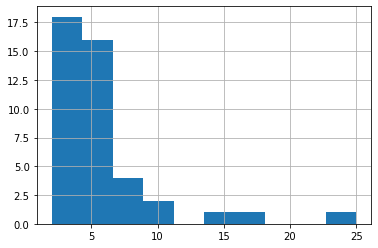

In [11]:
feat_categorical_nunique.hist()
plt.show()

💡 As a starter, what about simply removing all features that have **7 unique values or more**, and one-hot-encode every others? Let's keep ordinal encoding and statistical feature selection for the next iteration.

❓ Store features to OHE in a list `feat_categorical_small` below. How many features will be OHE?

In [12]:
# categorical features to one-hot-encode
feat_categorical_small = feat_categorical_nunique[feat_categorical_nunique < 7]
feat_categorical_small

MSZoning         5
Street           2
Alley            2
LotShape         4
LandContour      4
Utilities        2
LotConfig        5
LandSlope        3
BldgType         5
RoofStyle        6
MasVnrType       4
ExterQual        4
ExterCond        5
Foundation       6
BsmtQual         4
BsmtCond         4
BsmtExposure     4
BsmtFinType1     6
BsmtFinType2     6
Heating          6
HeatingQC        5
CentralAir       2
Electrical       5
KitchenQual      4
FireplaceQu      5
GarageType       6
GarageFinish     3
GarageQual       5
GarageCond       5
PavedDrive       3
PoolQC           3
Fence            4
MiscFeature      4
SaleCondition    6
dtype: int64

In [13]:
feat_categorical_small.sum()

147

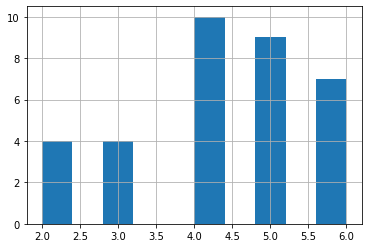

In [14]:
feat_categorical_small.hist()
plt.show()

In [15]:
# categorical features to one-hot-encode
feat_categorical_small = feat_categorical_small.keys()
feat_categorical_small

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'BldgType', 'RoofStyle', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleCondition'],
      dtype='object')

In [16]:
data[feat_categorical_small].head(3)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,BldgType,RoofStyle,...,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,1Fam,Gable,...,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,1Fam,Gable,...,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,1Fam,Gable,...,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,Normal


🧪 Test your code below (and clear the cell once it passed)

In [17]:
from nbresult import ChallengeResult
result = ChallengeResult('features_overview',
    n=len(feat_categorical_small))
result.write(); print(result.check())

============================= test session starts ==============================
platform darwin -- Python 3.8.6, pytest-6.2.3, py-1.10.0, pluggy-0.13.1 -- /Users/smrack/.pyenv/versions/3.8.6/envs/lewagon/bin/python3.8
cachedir: .pytest_cache
rootdir: /Users/smrack/code/olushO/data-challenges/05-ML/07-Ensemble-Methods/01-Houses-Kaggle-Competition
plugins: anyio-2.2.0, dash-1.20.0
collecting ... collected 1 item

tests/test_features_overview.py::TestFeaturesOverview::test_feat_categorical_small PASSED [100%]

============================== 1 passed in 0.02s ===============================


💯 You can commit your code:

git add tests/features_overview.pickle

git commit -m 'Completed features_overview step'

git push origin master


## Preprocessing pipeline - V1 minimal baseline

---
❓ Let's code the basic preprocessing pipeline described below. Save it under `preproc_baseline`.

For categorical features
- Simple-Impute with most frequent values
- One-Hot-Encode features that have less than 7 unique values to start with
- Drop all others features


As for numerical features
- Simple-Impute with strategy 'mean'
- Min-Max Scale 


<details>
    <summary>ℹ️ Pro tips</summary>

If you are confident, you can try sklearn's shorter syntax `make_pipeline` or `make_column_transformer` instead of the longer syntax `Pipeline` or `ColumnTransformer` if you want to avoid giving names manually to every steps.
</details>

In [18]:
# Dummy code your pipeline first
cat_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'),
                                OneHotEncoder(handle_unknown='ignore', 
                                              sparse=False)
                                )

num_transformer = make_pipeline(SimpleImputer(strategy='mean'),
                                MinMaxScaler()              
                                )

preproc_baseline = ColumnTransformer([
    ('num_transformer', num_transformer, make_column_selector(dtype_include=['int64','float64'])),
    ('cat_transformer', cat_transformer, feat_categorical_small)
])
preproc_baseline
# Code it for real below


ColumnTransformer(transformers=[('num_transformer',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x1252ddaf0>),
                                ('cat_transformer',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unkno...
       'LotConfig', 'LandSlope', 'BldgType', 'RoofStyle', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleCondition'],
      dtype='object'))])

In [19]:
preproc_X = pd.DataFrame(preproc_baseline.fit_transform(X))
preproc_X.head(3)

,0,1,2,3,4,5,6,7,8,9,...,173,174,175,176,177,178,179,180,181,182
0,0.235294,0.150685,0.033420,0.666667,0.500,0.949275,0.883333,0.12250,0.125089,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.753623,0.433333,0.00000,0.173281,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.934783,0.866667,0.10125,0.086109,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


❓ Look at the **shape** of your preprocessed dataframe.

In [20]:
shape_preproc_baseline = preproc_X.shape

🧪 Test your code below

In [21]:
from nbresult import ChallengeResult
result = ChallengeResult('preproc_baseline',
    shape=shape_preproc_baseline)
result.write()
print(result.check())

============================= test session starts ==============================
platform darwin -- Python 3.8.6, pytest-6.2.3, py-1.10.0, pluggy-0.13.1 -- /Users/smrack/.pyenv/versions/3.8.6/envs/lewagon/bin/python3.8
cachedir: .pytest_cache
rootdir: /Users/smrack/code/olushO/data-challenges/05-ML/07-Ensemble-Methods/01-Houses-Kaggle-Competition
plugins: anyio-2.2.0, dash-1.20.0
collecting ... collected 1 item

tests/test_preproc_baseline.py::TestPreprocBaseline::test_shape PASSED   [100%]

============================== 1 passed in 0.02s ===============================


💯 You can commit your code:

git add tests/preproc_baseline.pickle

git commit -m 'Completed preproc_baseline step'

git push origin master


## Model baseline

❓ Pipe a basic Ridge regressor to your `preproc_baseline` and store it to `pipe_baseline` variable.

In [22]:
pipe_baseline = Pipeline([
    ('preprocessor', preproc_baseline),
    ('regressor', Ridge())
])
pipe_baseline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1252ddaf0>),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc...
       'LotConfig', 'LandSlope', 'BldgType', 'RoofStyle', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleCondition'],
      dtype='object'))])),
                ('regressor', Ridge())])

❓ Read the Kaggle [contest evaluation rules](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation) 
- Which performance metric do you need? Is it readily available in sklearn?
- Create a scorer using [`make_scorer`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) and store it into a variable named `rmsle`
- Create also the negative score `rmsle_neg` which is best when _maximized_. This will come handy later as `GridSearchCV` requires a score to _maximize_

In [23]:
pipe_baseline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1252ddaf0>),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc...
       'LotConfig', 'LandSlope', 'BldgType', 'RoofStyle', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleCondition'],
      dtype='object'))])),
                ('regressor', Ridge())])

In [ ]:
pipe_baseline.predict(X).min()

In [ ]:
pipe_baseline.score(X, y)

In [ ]:
def make_rmsle(X, y):
    return mean_squared_log_error(X, y)**0.5


rmsle = make_scorer(make_rmsle, greater_is_better=True)

rmsle_neg = make_scorer(make_rmsle, greater_is_better=False)

❓5-fold cross_validate your `pipe_baseline` using this metric to get a first glance at your baseline perf.    
Store your mean score as `score_baseline`

In [ ]:
score_baseline = cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle).mean()
score_baseline

## Predict baseline

❓ Predict `y_pred_baseline` from the Kaggle `test.csv` dataset you stored in the `data` folder.

In [ ]:
X_test = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_test_raw.csv")

In [ ]:
Id_test = X_test['Id']
X_test.drop(columns='Id', inplace=True)

In [ ]:
Id_test

In [ ]:
y_pred_baseline = pipe_baseline.predict(X_test)
y_pred_baseline

❓ Finally, store your CSV ready to be submitted as `submission_baseline.csv` in the `data` folder. Read carefully the Kaggle required format and test it below (you don't need to submit this baseline online for now).

In [ ]:
submission_baseline = pd.concat([Id_test, pd.DataFrame(y_pred_baseline)], axis=1)
submission_baseline.columns = ['Id','SalePrice']

In [ ]:
submission_baseline.head(3)

In [ ]:
submission_baseline.to_csv(path_or_buf='data/submission_baseline.csv', index=False)

In [ ]:
!ls data/

🧪 Test your code

In [ ]:
from nbresult import ChallengeResult
tmp = pd.read_csv("data/submission_baseline.csv")
result = ChallengeResult('submission_baseline',
    score_baseline = score_baseline,
    submission_shape = tmp.shape,
    submission_columns = list(tmp.columns),
    submission_dtypes = str(list(tmp.dtypes)),
)
result.write()
print(result.check())

# 🏋️‍♀️ ITERATIONS 

🎉 🎉 Congratulation for having fully pipelined a basline model! You will see now how easier it is to iterate and improve performance 🚀

- Your goal is to improve your prediction and submit it by **16h30 max online**
- We suggested you some improvements below
- **Pick up your fights** and **incrementally** improve your pipeline as you see fit

**Models**

- Linear Models: fine-tune regularization ?
- **Tree-based ensembles (must try today)**: Probably the best suited for many categorical-features problems
- Stacking !
- ...

**Preprocessing** (once your first ensemble models works)

- Ordinal Encoding of categorical features with a hidden notion of order in their values (e.g. "bad", "average", good")
- Statistical Feature Selection to remove useless features (avoid overfitting and reduce train time)
- Predict log(SalePrice) instead?
- ...

## Preprocessing Iteration (⚠️ come back here after your first Ensemble model)

⏩ Collapse me if you don't use me!

### Ordinal Encoding (1h)

❓ Look at the following feature below. Couldn't it be encoded numerically in a wise manner?
```
ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
```

💡 Luckily, the `OrdinalEncoder` and its argument `categories`  allows us to do just that. Check it out below and make sure to understand how ths works

In [ ]:
# Define specific order for features
# Note: if you change this order, it will change the output for .transform()
feature_A_sorted_values = ['bad', 'average', 'good'] 
feature_B_sorted_values = ['dirty', 'clean', 'new']

encoder = OrdinalEncoder(
    categories=[
        feature_A_sorted_values,
        feature_B_sorted_values
    ],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

# Just some random training data
XX = [
    ['good', 'dirty'],
    ['bad', 'new'],
    ['average', 'clean'],
]

encoder.fit(XX)

encoder.transform([
        ['bad', "dirty"],
        ['good', 'new'],
        ['bad', 'oooops never seen this label before']
])

---
❓ **Your turn**: split your categorical preprocessor into

- `preproc_ordinal` to ordinally encode **some features** of your choice (**do a quick iteration first**)
- `preproc_nominal` to one hot encode the other ones


<details>
    <summary>Hints</summary>

- You won't be able to avoid hard-coding names and ordered values of features! Be tidy!
- It's a good practice to sort alphabetically your features to avoid bad surprises
</details>

### Target engineering (15 min)

❓ We are asked to minimize the RMS**L**E. Why don't we transform our target to directly predict its log?
- Check-out historgram of your target `y`. Normally distributed variables should be easier to predict with linear models. 
- Create `y_log` and your new performance metrics
- Don't forget at the end to take the exponential of your predictions!

### Statistical Feature Selection (1h)

Our goal is to remove the least interesting features, to limit overfitting and shorten training time.  
Choose one of the 3 options below

#### (option 1 - recommended) univariate feature selection based on relationship with target `y`

❓ We will use sklearn's [feature selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) tools directly in your pipeline.
- Add a `SelectPercentile` filter (coupled with `mutual_info_regression` for the statistical test to use) at the end of your `preproc` pipeline.
- This will filter-out features that, - taken individually - least explain your target!  

#### (option 2) multivariate feature selection based their common relationship with target `y`

❓ We will use sklearn's [feature selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) tools directly in your pipeline.
- Add a `SequentialFeatureSelector` at the end of your `preproc` pipeline.
- This will recursively filter-out least important features according to `feature_permutation` importance!  
- Probably overkill for such small dataset!

#### (option 3) Filter based only on the properties of `X` ?

❓ Use Pearson's correlation combined with a heatmap...
- to check visually whether some **numerical** features almost entirely explain others. 
- Then, create a "filter" in your pipeline that removes any correlated below a certain threshold

❓ Use [Spearman's rank correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) combined with a heatmap...
- to whether some **ordinally encoded** features are almost entirely "ordered" similarily than others
- Then, create a "filter" in your pipeline that removes any ordinal features correlated below a certain threshold

❓ Another way to filter out feature relies solely on removing those with the lowest variance.  
- Think about it: a feature which only takes one value is useless (and has a variance of 0).  
- Try to add a `VarianceThreshold` to the end of your pipeline

### Final preproc pipeline
❓ store here your final version of the preproc pipeline

## Models Iteration

# 🏅FINAL SUBMISSION (start at 4h30 max)

Discover your real test score by submitting on Kaggle! 

👉 Write down your test score on the [result spreadsheet here](https://docs.google.com/spreadsheets/d/1ZEBKwa_k1Ytb0WCOh-Nopq3eaezwBNu1SAqKXEXRguc/edit#gid=0) (pick the correct batch!)

In [ ]:
X_test = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_test_raw.csv")